## Imports


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, log_loss, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.dates import DateFormatter

import shap 


## Loading the data
Filtering on Neude for the first step of the process

In [2]:
data_sensors_utrecht_path = '../Sensor data Utrecht.csv'
data_sensors_utrecht = pd.read_csv(data_sensors_utrecht_path, delimiter=';')

# Convert Timestamp column to datetime
data_sensors_utrecht['date'] = pd.to_datetime(data_sensors_utrecht['date'], errors='coerce', utc=True)
data_sensors_neude = data_sensors_utrecht[data_sensors_utrecht['location name'] == 'Neude']



## Visualization of the data
Heatmap of the average occupancy of the loadingzone in Neude

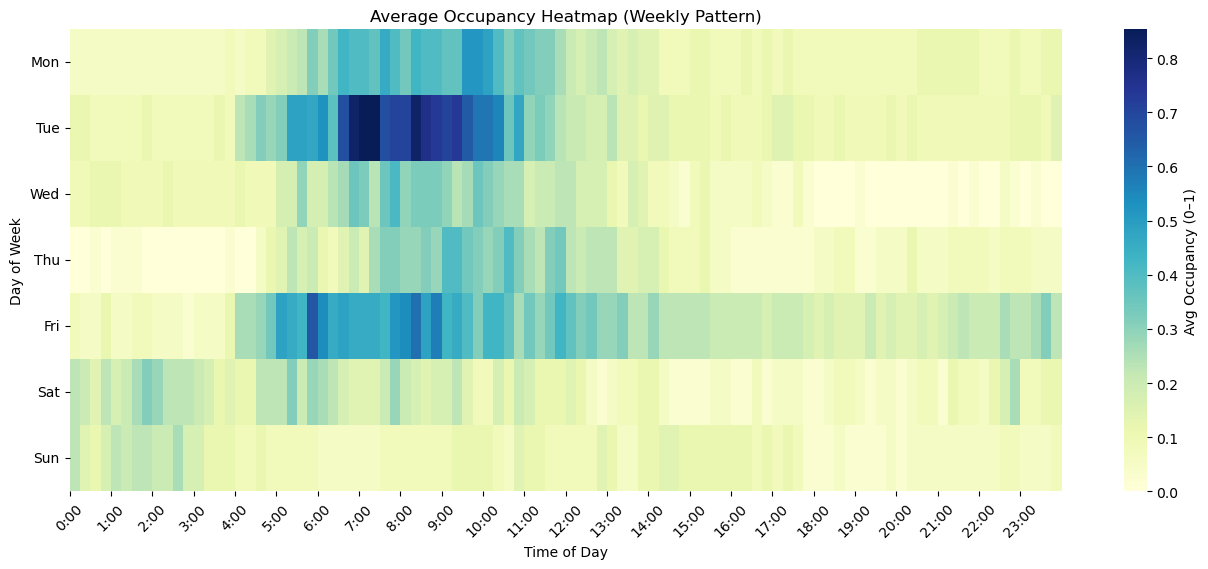

In [28]:
heatmap_data = data_sensors_neude.copy()

heatmap_data['status'] = heatmap_data['status'].astype(int)
heatmap_data = heatmap_data.sort_values('date')
heatmap_data = heatmap_data.set_index('date').resample('15min').ffill().reset_index()
heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek
heatmap_data['slot'] = heatmap_data['date'].dt.hour * 4 + heatmap_data['date'].dt.minute // 15

heatmap_data = heatmap_data.groupby(['day_of_week','slot'])['status'].mean().unstack()
heatmap_data = heatmap_data.astype(float)  # force numeric

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label':'Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i) + ":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()

Heatmaps of the sensor data in Neude in different months

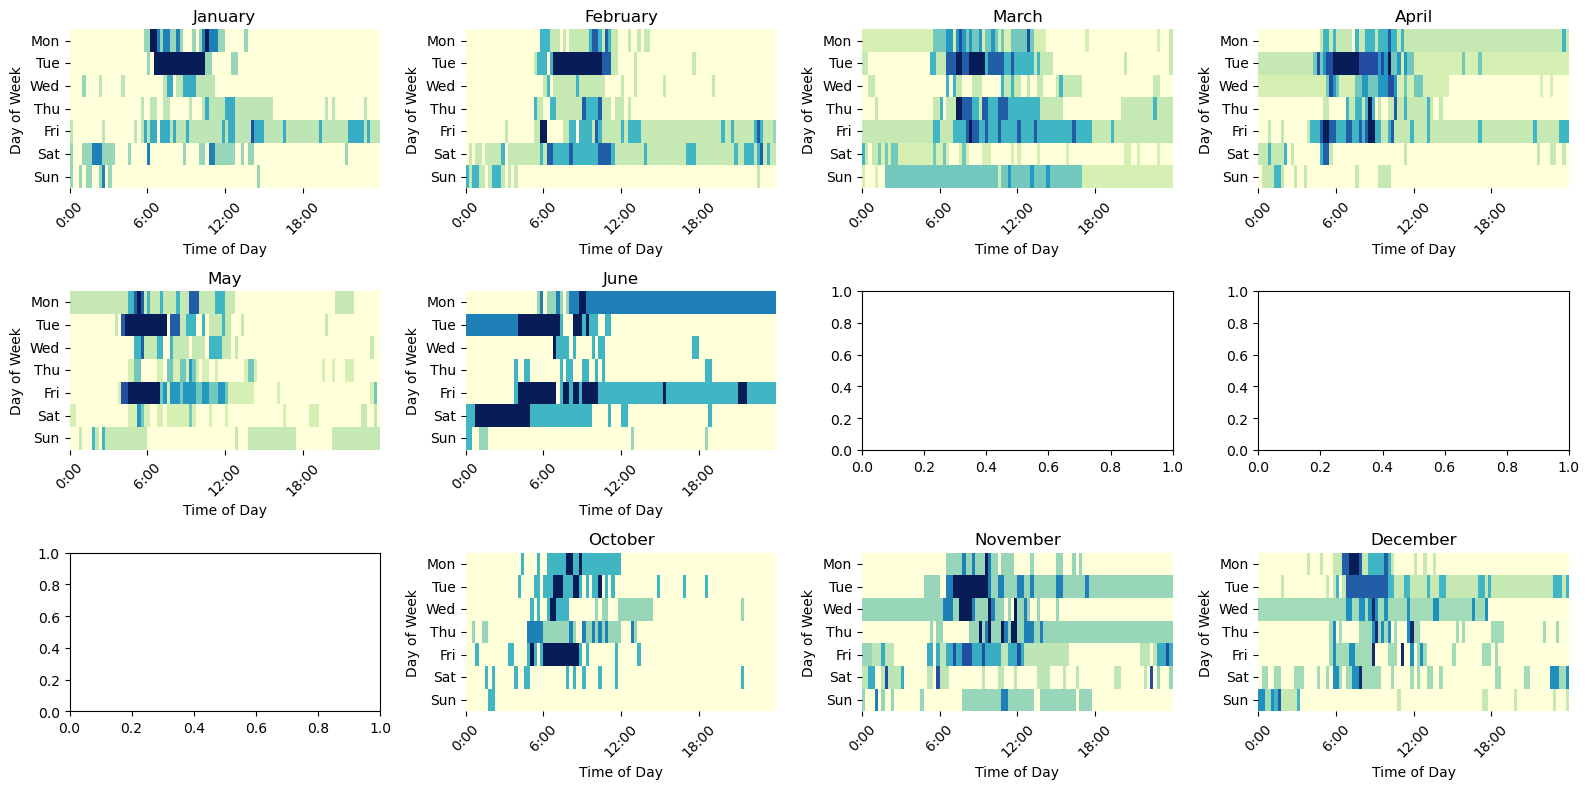

In [4]:

data = data_sensors_neude.copy()
data['status'] = data['status'].astype(int)
data['month'] = data['date'].dt.month  # voeg maand toe

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for month in range(1, 13):
    # Filter data voor de maand
    heatmap_data = data[data['month'] == month].copy()

    if heatmap_data.empty:
        continue  # sla over als er geen data is voor die maand

    # Zelfde verwerking als eerder
    heatmap_data = heatmap_data.sort_values('date')
    heatmap_data = (
        heatmap_data.set_index('date')
        .resample('15min')
        .ffill()
        .reset_index()
    )
    heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek
    heatmap_data['slot'] = heatmap_data['date'].dt.hour * 4 + heatmap_data['date'].dt.minute // 15

    # Groeperen en omvormen
    heatmap_data = (
        heatmap_data.groupby(['day_of_week', 'slot'])['status']
        .mean()
        .unstack()
        .astype(float)
    )
    

    ax = axes[month - 1]
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=False, ax=ax)
    ax.set_title(pd.to_datetime(f'2024-{month:02d}-01').strftime('%B'))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")

    xticks = np.arange(0, 96, 24)  # bijvoorbeeld elke 6 uur
    xlabels = [f"{i}:00" for i in range(0, 24, 6)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

# Zorg voor goede spacing
plt.tight_layout()
plt.show()

## Feature engineering
Preparing the data to use for the XGBoost model. Making the rolling windows, lag features and 15-min slots.

In [20]:
# Copy original dataset
data = data_sensors_neude.copy()

# Ensure integer status
data['status'] = data['status'].astype(int)

# Regularize timeseries
data = data.sort_values('date')
data = data.set_index('date').resample('15min').ffill().reset_index()

# Time features
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['day_of_month'] = data['date'].dt.day
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
data['time_of_day'] = data['slot'] / 96
data['dow_slot'] = data['day_of_week'].astype(str) + "_" + data['slot'].astype(str)

# Lag features
lags = [1, 2, 3, 4, 12, 24, 96, 672]
for lag in lags:
    data[f'status_lag_{lag}'] = data['status'].shift(lag)

# Rolling features
rolling_windows = {
    '1h': 4,
    '3h': 12, 
    '6h': 24, 
    '1d': 96, 
    '1w': 672
}
for name, window in rolling_windows.items():
    data[f'status_roll_mean_{name}'] = data['status'].rolling(window).mean().shift(1)
    data[f'status_roll_max_{name}'] = data['status'].rolling(window).max().shift(1)
    data[f'status_roll_min_{name}'] = data['status'].rolling(window).min().shift(1)
    data[f'status_roll_sum_{name}'] = data['status'].rolling(window).sum().shift(1)

# Drop NaNs after lag/rolling
data = data.dropna().reset_index(drop=True)


## Model training
Selecting which features to use and splitting the train and test set

In [21]:
features = [
    'day_of_week','month','day_of_month','is_weekend','time_of_day','dow_slot',
    'status_lag_1','status_lag_2','status_lag_3','status_lag_4',
    'status_lag_12','status_lag_24','status_lag_96', 'status_lag_672',
    'status_roll_mean_1h','status_roll_max_1h','status_roll_min_1h','status_roll_sum_1h',
    'status_roll_mean_3h','status_roll_max_3h','status_roll_min_3h','status_roll_sum_3h',
    'status_roll_mean_6h','status_roll_max_6h','status_roll_min_6h','status_roll_sum_6h',
    'status_roll_mean_1d','status_roll_max_1d','status_roll_min_1d','status_roll_sum_1d',
    'status_roll_mean_1w','status_roll_max_1w','status_roll_min_1w','status_roll_sum_1w'
]

X = data[features]
X['dow_slot'] = X['dow_slot'].astype('category')  # categorical encoding
y = data['status'].astype(float)  # regression target (probability 0–1)

# Train/test split (last 20% is test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


C:\Users\olafh\AppData\Local\Temp\ipykernel_28164\2460993517.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dow_slot'] = X['dow_slot'].astype('category')  # categorical encoding


## Model selection
Using XGBoost with regression

In [22]:
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    enable_categorical=True,
    random_state=42,
)

model.fit(X_train, y_train)

# Predictions on test set
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred,0,1)


# Feature Selection Techniques
Some plots that show the importance of the features and checking if some features are not contributing enough.

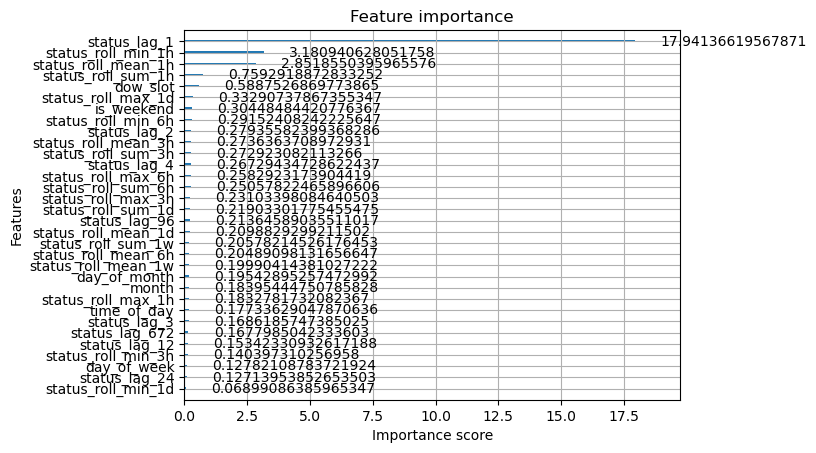

In [23]:
xgb.plot_importance(model, importance_type='gain', max_num_features=35)
plt.show()

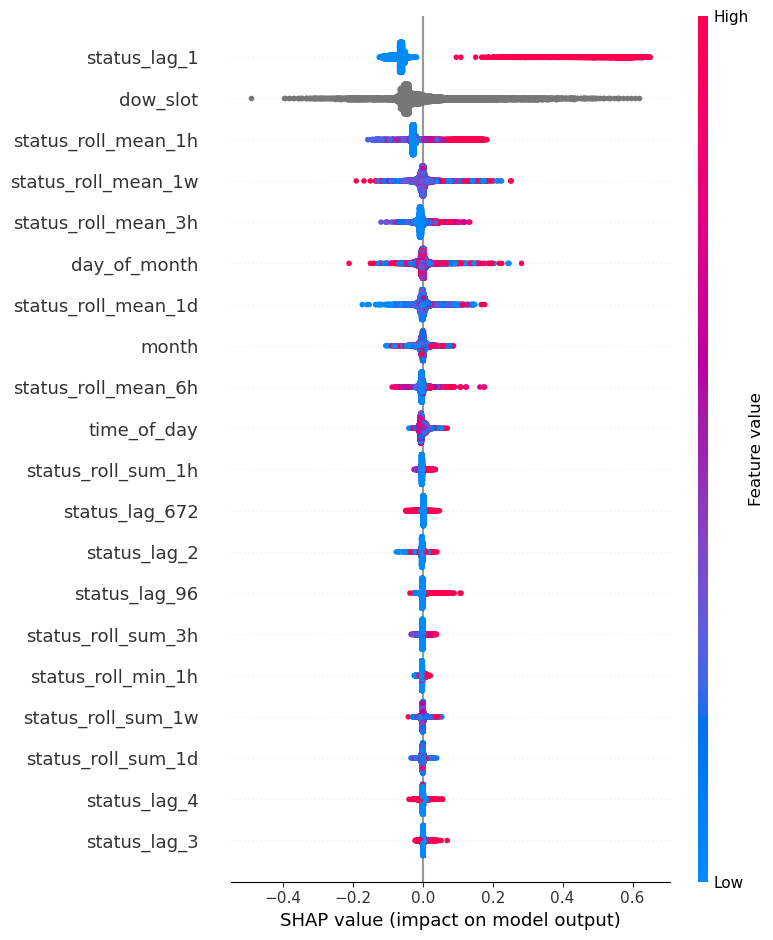

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

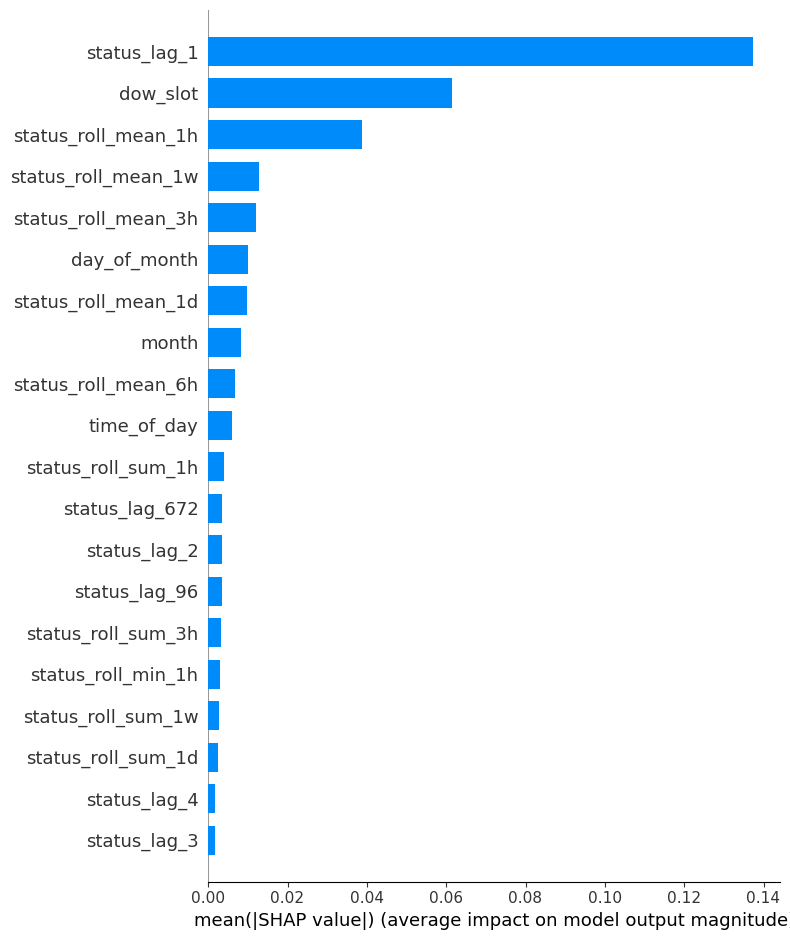

In [33]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Model evaluation
evaluating the model using the logloss metric

In [8]:
# Evaluate
logloss = log_loss(y_test, y_pred)
rog_auc = roc_auc_score(y_test, y_pred)
print(f"Test log loss: {logloss:.4f} | ROG AUC: {rog_auc:.4f}")

Test log loss: 0.2872 | ROG AUC: 0.9250


## Results visualization
Heatmap of the test set data, showing the average occupancy of the spot in 15-min intervals in Neude.

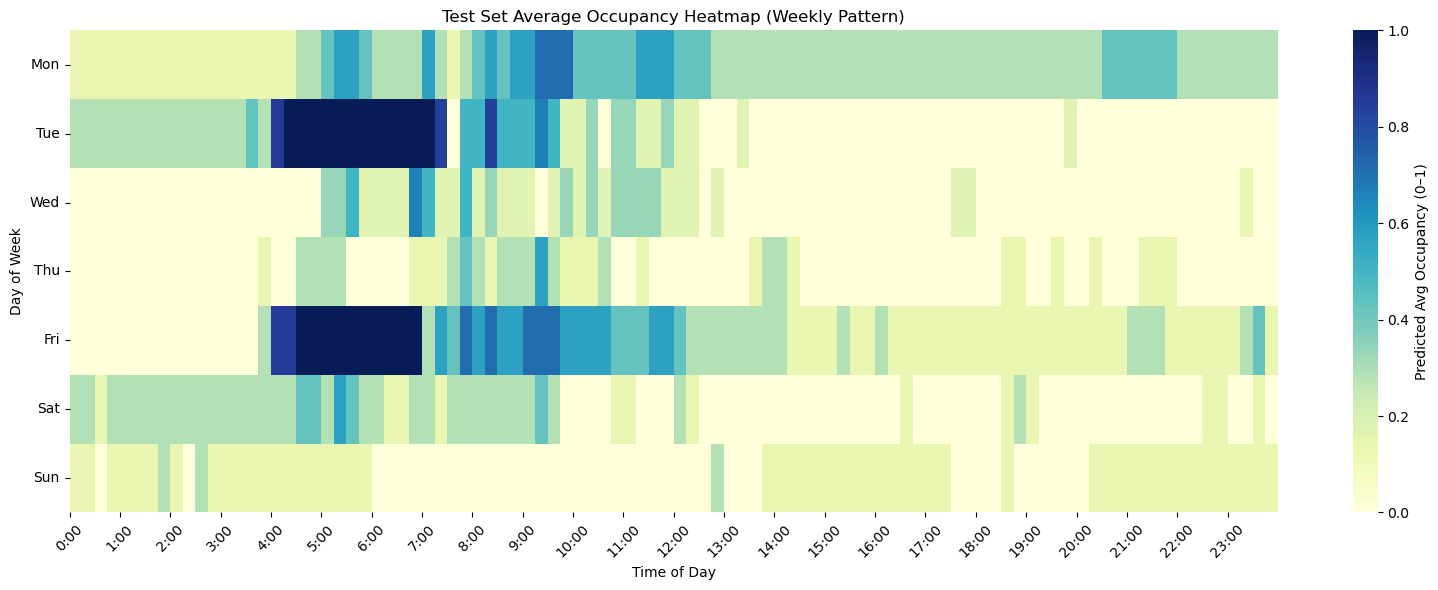

In [26]:
X_test["occupancy"] = y_test

X_test['slot'] = X_test['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    X_test.groupby(["day_of_week", "slot"])["occupancy"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Test Set Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Heatmap of the predicted data, showing the predicted occupancy of the spot in the 15-min slots in Neude.

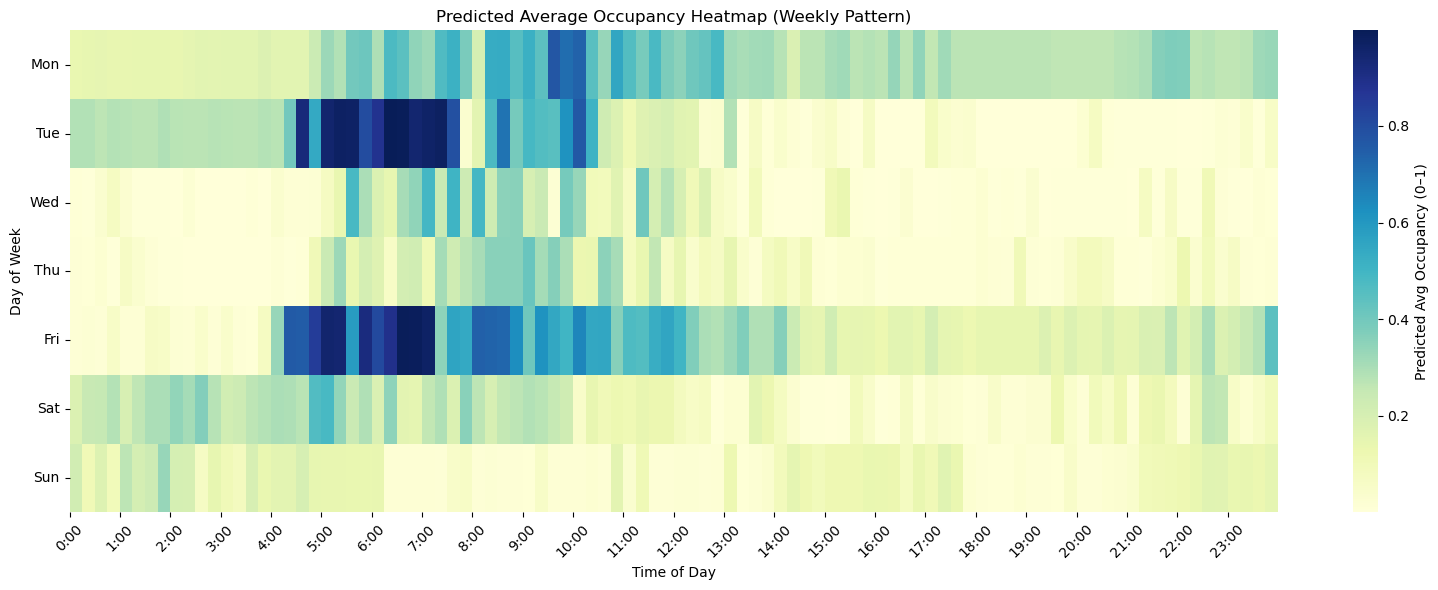

In [10]:
data_pred = X_test.copy()
data_pred["prediction"] = y_pred

data_pred['slot'] = data_pred['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    data_pred.groupby(["day_of_week", "slot"])["prediction"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Lineplot of the predicted occupancy against the true occupancy in the test set for the spot in Neude.

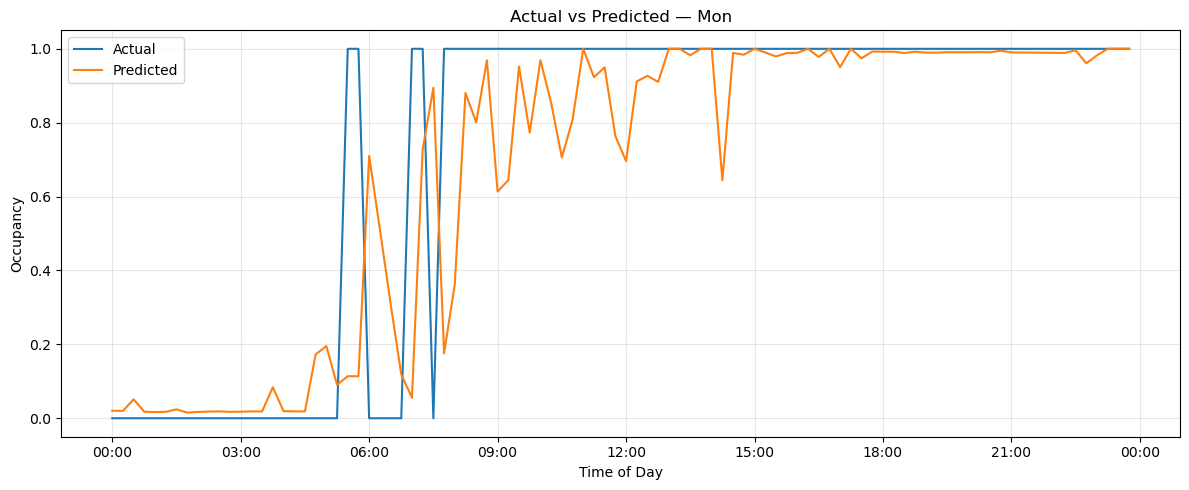

In [11]:

df = X_test.copy()
df["y_true"] = y_test
df["y_pred"] = y_pred


df[["day_of_week","slot"]] = (
    df["dow_slot"].astype(str).str.split("_", expand=True).astype(int)
)


dow = 0
dom = 16
m = 6

day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
title_day = day_names[dow]

day_df = (df[(df["day_of_week"] == dow) & (df["day_of_month"] == dom) & (df["month"] == m)]
          .groupby("slot")[["y_true","y_pred"]]
          .mean()
          .reset_index()
          .sort_values("slot"))


time_base = pd.to_datetime("2000-01-01")  # arbitraire datum
day_df["time"] = time_base + pd.to_timedelta(day_df["slot"] * 15, unit="m")


plt.figure(figsize=(12,5))
plt.plot(day_df["time"], day_df["y_true"], label="Actual")
plt.plot(day_df["time"], day_df["y_pred"], label="Predicted")
plt.title(f"Actual vs Predicted — {title_day}")
plt.xlabel("Time of Day")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(alpha=0.3)

# Mooie tijdlabels
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.tight_layout()
plt.show()

## Forecasting for Dashboard
Here we made a forcasting of a week that we can later use in the dashboard. For now this is not complete or correct. 

In [16]:
# Get last history needed for rolling features
max_lag = max(lags)
max_window = max(rolling_windows.values())
n_rows_needed = max(max_lag, max_window)

last_data = data.tail(n_rows_needed).copy().reset_index(drop=True)

forecast_horizon = 96 * 7  # 1 week (15min slots)
pred_timestamps = []
pred_values = []

current_data = last_data.copy()

for i in range(forecast_horizon):
    last_timestamp = current_data['date'].iloc[-1] + pd.Timedelta(minutes=15)
    
    features_step = {
        'day_of_week': last_timestamp.dayofweek,
        'month': last_timestamp.month,
        'day_of_month': last_timestamp.day,
        'is_weekend': int(last_timestamp.dayofweek >= 5),
        'slot': last_timestamp.hour * 4 + last_timestamp.minute // 15,
    }
    features_step['time_of_day'] = features_step['slot'] / 96
    features_step['dow_slot'] = f"{features_step['day_of_week']}_{features_step['slot']}"
    
    
    for lag in lags:
        features_step[f'status_lag_{lag}'] = current_data['status'].iloc[-lag]
    
    # Add rolling stats
    for name, window in rolling_windows.items():
        features_step[f'status_roll_mean_{name}'] = current_data['status'].iloc[-window:].mean()
        features_step[f'status_roll_max_{name}'] = current_data['status'].iloc[-window:].max()
        features_step[f'status_roll_min_{name}'] = current_data['status'].iloc[-window:].min()
        features_step[f'status_roll_sum_{name}'] = current_data['status'].iloc[-window:].sum()
    
    # Prediction
    X_pred = pd.DataFrame([features_step])[features]
    X_pred['dow_slot'] = X_pred['dow_slot'].astype('category')
    y_next = model.predict(X_pred)[0]
    y_next = np.clip(y_next, 0.0, 1.0)
    
    pred_timestamps.append(last_timestamp)
    pred_values.append(y_next)
    
    # Append prediction to current_data
    new_row = pd.DataFrame({'date':[last_timestamp], 'status':[y_next]})
    current_data = pd.concat([current_data, new_row], ignore_index=True)

# Forecast dataframe
forecast_df = pd.DataFrame({
    'date': pred_timestamps,
    'status_pred': pred_values
})


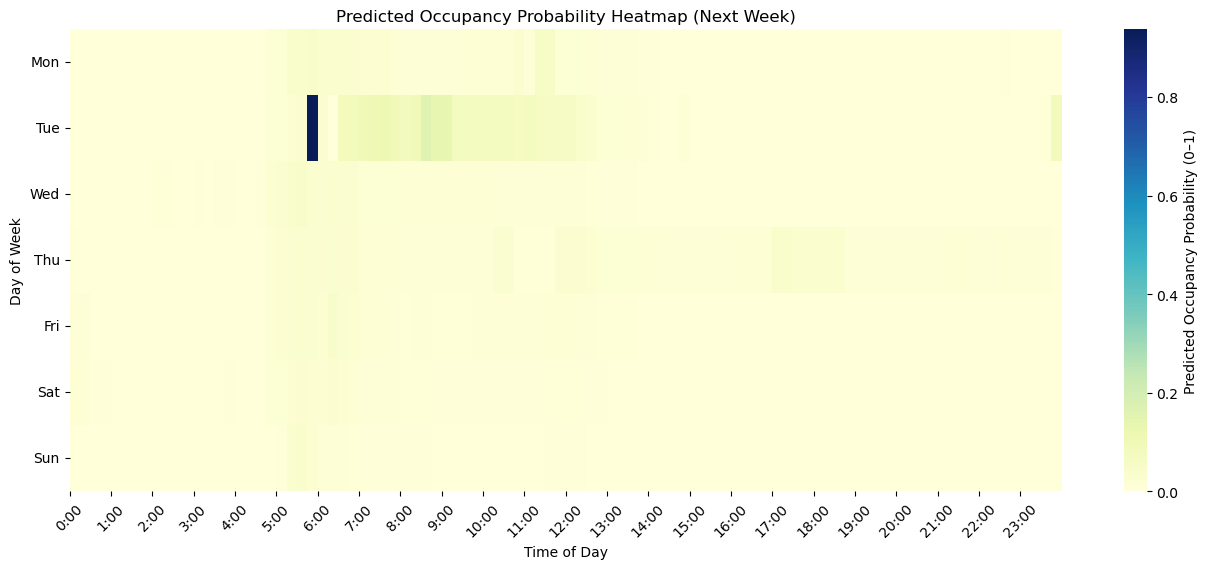

In [17]:
forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_matrix, cmap="YlGnBu", cbar_kws={'label':'Predicted Occupancy Probability (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Occupancy Probability Heatmap (Next Week)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i)+":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()
